In [1]:
import sys
sys.path.append("../code/")

from importlib import reload  
import lib_LinearAlgebra
lib_LinearAlgebra = reload(lib_LinearAlgebra)

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats

# Simulate with intercept

In [2]:
n = 100
k = 3
n_outcome = 4
kcovar = 2
beta = np.reshape(np.array(range(1, k * n_outcome + 1)), newshape = [k, n_outcome])
bcovar = np.reshape(np.array(range(1, kcovar * n_outcome + 1)), newshape = [kcovar, n_outcome]) * 0.2
intercepts = np.array([230, 250, 270, 290])

x = np.random.normal(size = [n, k])
covar = np.random.normal(size = [n, kcovar])
y = np.matmul(x, beta) + np.matmul(covar, bcovar) + np.random.normal(size = [n, n_outcome]) + intercepts

In [3]:
dataset = tf.data.Dataset.from_tensor_slices((x, np.concatenate((y, covar), axis = 1)))
dataset = dataset.map(lambda x, y: (tf.cast(x, tf.float32), tf.cast(y, tf.float32)))

In [4]:
dataset = dataset.batch(7)

In [5]:
data_scheme = lib_LinearAlgebra.DataScheme(
    dataset = dataset, 
    X_index = 0,
    Y_index = 1,
    outcome_indice = [0, 1, 2, 3], 
    covariate_indice = [4, 5]
)

## The right thing

In [6]:
least_square_solver = lib_LinearAlgebra.LeastSquaredEstimator(data_scheme, intercept = True)

In [7]:
least_square_solver.solve()

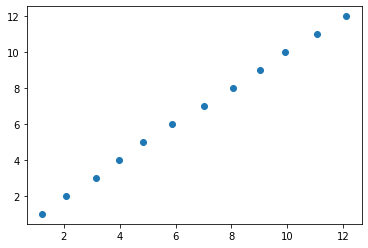

In [8]:
plt.scatter(least_square_solver.get_betahat_x(), beta)

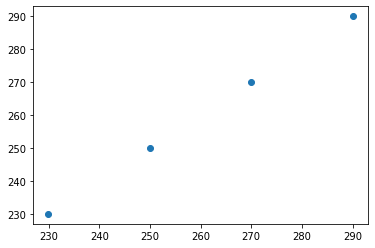

In [9]:
plt.scatter(least_square_solver.get_intercept(), intercepts)

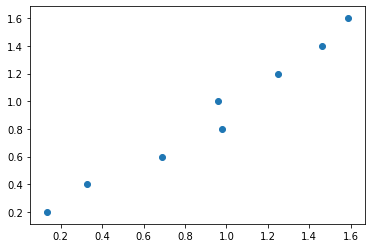

In [10]:
plt.scatter(least_square_solver.get_betahat_covar(), bcovar)

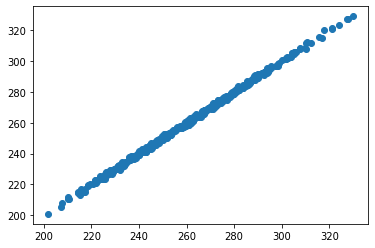

In [11]:
y_pred = least_square_solver.predict(dataset)
plt.scatter(y_pred['y_pred'], y_pred['y'])

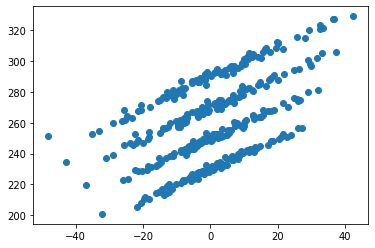

In [12]:
y_pred = least_square_solver.predict_x(dataset)
plt.scatter(y_pred['y_pred_from_x'], y_pred['y'])

## No intercept

In [13]:
least_square_solver = lib_LinearAlgebra.LeastSquaredEstimator(data_scheme, intercept = False)
least_square_solver.solve()

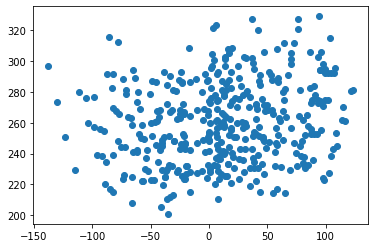

In [14]:
y_pred = least_square_solver.predict(dataset)
plt.scatter(y_pred['y_pred'], y_pred['y'])

# Simulate without intercept

In [15]:
n = 100
k = 3
n_outcome = 4
kcovar = 2
beta = np.reshape(np.array(range(1, k * n_outcome + 1)), newshape = [k, n_outcome])
bcovar = np.reshape(np.array(range(1, kcovar * n_outcome + 1)), newshape = [kcovar, n_outcome]) * 0.2
# intercepts = np.array([230, 250, 270, 290])

x = np.random.normal(size = [n, k])
covar = np.random.normal(size = [n, kcovar])
y = np.matmul(x, beta) + np.matmul(covar, bcovar) + np.random.normal(size = [n, n_outcome]) # + intercepts

dataset = tf.data.Dataset.from_tensor_slices((x, np.concatenate((y, covar), axis = 1)))
dataset = dataset.map(lambda x, y: (tf.cast(x, tf.float32), tf.cast(y, tf.float32)))
dataset = dataset.batch(7)
data_scheme = lib_LinearAlgebra.DataScheme(
    dataset = dataset, 
    X_index = 0,
    Y_index = 1,
    outcome_indice = [0, 1, 2, 3], 
    covariate_indice = [4, 5]
)

## With intercept

In [16]:
least_square_solver = lib_LinearAlgebra.LeastSquaredEstimator(data_scheme, intercept = True)
least_square_solver.solve()


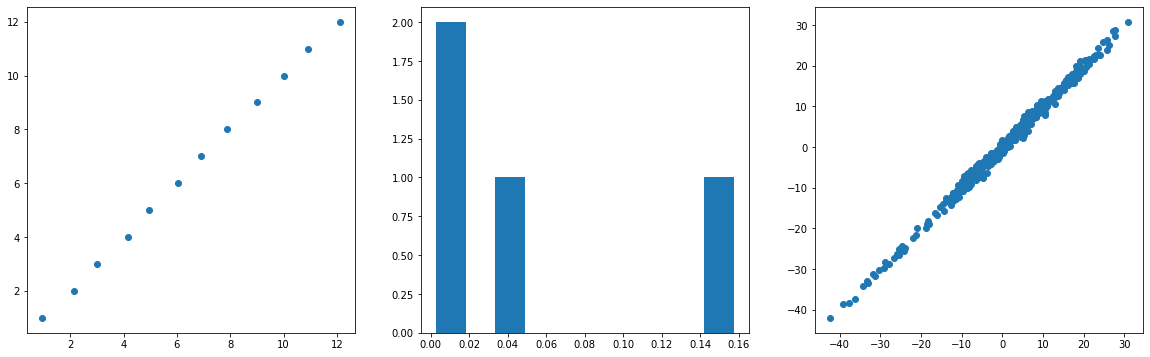

In [17]:
fig, axe = plt.subplots(ncols = 3, nrows = 1, figsize = (20, 6))
axe[0].scatter(least_square_solver.get_betahat_x(), beta)
axe[1].hist(least_square_solver.get_intercept())
y_pred = least_square_solver.predict(dataset)
axe[2].scatter(y_pred['y_pred'], y_pred['y'])

## Without intercept

In [18]:
least_square_solver = lib_LinearAlgebra.LeastSquaredEstimator(data_scheme, intercept = False)
least_square_solver.solve()


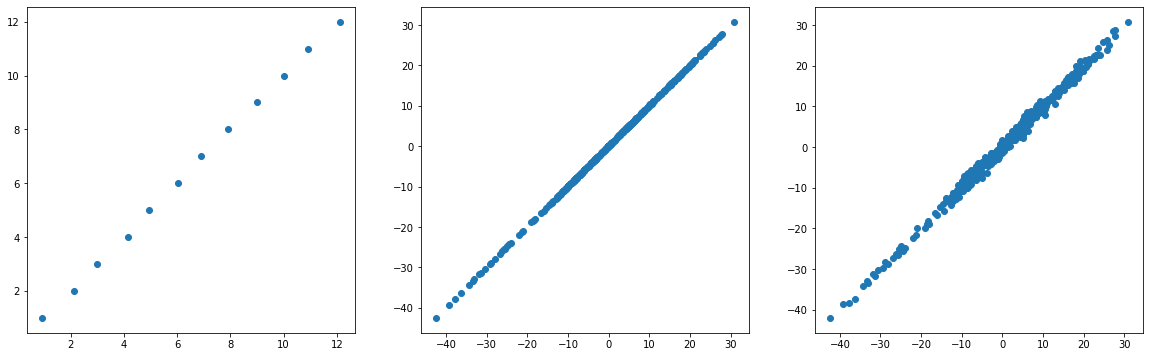

In [19]:
fig, axe = plt.subplots(ncols = 3, nrows = 1, figsize = (20, 6))
axe[0].scatter(least_square_solver.get_betahat_x(), beta)
y_pred2 = least_square_solver.predict(dataset)
axe[1].scatter(y_pred2['y_pred'], y_pred['y_pred'])
axe[2].scatter(y_pred2['y_pred'], y_pred2['y'])

# Testing minimal save and load

Saving betahat
Saving intercept
Saving normalizer
Saving data_scheme.dataset
Saving data_scheme.X_index
Saving data_scheme.Y_index
Saving data_scheme.outcome_indice
Saving data_scheme.covariate_indice
Saving data_scheme.num_predictors
DescribeResult(nobs=100, minmax=(array([0., 0., 0., 0.], dtype=float32), array([0., 0., 0., 0.], dtype=float32)), mean=array([0., 0., 0., 0.], dtype=float32), variance=array([0., 0., 0., 0.], dtype=float32), skewness=array([0., 0., 0., 0.], dtype=float32), kurtosis=array([-3., -3., -3., -3.], dtype=float32))
DescribeResult(nobs=100, minmax=(array([0., 0., 0., 0.], dtype=float32), array([0., 0., 0., 0.], dtype=float32)), mean=array([0., 0., 0., 0.], dtype=float32), variance=array([0., 0., 0., 0.], dtype=float32), skewness=array([0., 0., 0., 0.], dtype=float32), kurtosis=array([-3., -3., -3., -3.], dtype=float32))


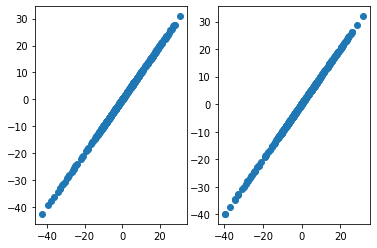

In [20]:
least_square_solver.minimal_save('test.hdf5')
loaded_solver = lib_LinearAlgebra.LeastSquaredEstimator('')
loaded_solver.minimal_load('test.hdf5')

y_pred2_x = loaded_solver.predict_x(dataset)
y_pred2 = loaded_solver.predict(dataset)

y_pred_x = least_square_solver.predict_x(dataset)
y_pred = least_square_solver.predict(dataset)

fig, axe = plt.subplots(nrows = 1, ncols = 2)
axe[0].scatter(y_pred['y_pred'], y_pred2['y_pred'])
axe[1].scatter(y_pred_x['y_pred_from_x'], y_pred2_x['y_pred_from_x'])
print(scipy.stats.describe(y_pred['y_pred'] - y_pred2['y_pred']))
print(scipy.stats.describe(y_pred_x['y_pred_from_x'] - y_pred2_x['y_pred_from_x']))

# Testing scaling

In [21]:
least_square_solver_noscale = lib_LinearAlgebra.LeastSquaredEstimator(data_scheme, intercept = False)
least_square_solver_noscale.solve(scaling = False)

In [22]:
least_square_solver_noscale.betahat / least_square_solver.betahat

<tf.Tensor: shape=(5, 4), dtype=float32, numpy=
array([[1.0000004 , 1.0000005 , 1.0000007 , 1.0000006 ],
       [0.9999997 , 0.99999994, 0.9999997 , 0.9999998 ],
       [1.        , 0.9999998 , 0.9999998 , 1.        ],
       [1.0000051 , 1.0000038 , 1.0000032 , 1.0000031 ],
       [0.99999976, 1.        , 1.0000005 , 0.9999999 ]], dtype=float32)>

# Testing logging

In [23]:
import logging, sys
logging.basicConfig(
    level = logging.INFO, 
    stream = sys.stderr, 
    format = '%(asctime)s  %(message)s',
    datefmt = '%Y-%m-%d %I:%M:%S %p'
)
least_square_solver_noscale.solve(logging = logging, sample_size = 100)

2020-02-01 04:18:58 PM  Progress 5%: 7 / 100
2020-02-01 04:18:58 PM  Progress 10%: 14 / 100
2020-02-01 04:18:58 PM  Progress 20%: 21 / 100
2020-02-01 04:18:58 PM  Progress 25%: 28 / 100
2020-02-01 04:18:58 PM  Progress 30%: 35 / 100
2020-02-01 04:18:58 PM  Progress 40%: 42 / 100
2020-02-01 04:18:58 PM  Progress 45%: 49 / 100
2020-02-01 04:18:58 PM  Progress 55%: 56 / 100
2020-02-01 04:18:58 PM  Progress 60%: 63 / 100
2020-02-01 04:18:58 PM  Progress 65%: 70 / 100
2020-02-01 04:18:58 PM  Progress 75%: 77 / 100
2020-02-01 04:18:58 PM  Progress 80%: 84 / 100
2020-02-01 04:18:58 PM  Progress 90%: 91 / 100
2020-02-01 04:18:58 PM  Progress 95%: 98 / 100
2020-02-01 04:18:58 PM  Progress 100%: 100 / 100


# Testing full normalization

In [24]:
n = 200
k = 300
n_outcome = 4
kcovar = 7
beta = np.reshape(np.array(range(1, k * n_outcome + 1)), newshape = [k, n_outcome])
bcovar = np.reshape(np.array(range(1, kcovar * n_outcome + 1)), newshape = [kcovar, n_outcome]) * 0.2
intercepts = np.array([230, 250, 270, 290])

x = np.random.normal(size = [n, k])
covar = np.random.normal(size = [n, kcovar])
y = np.matmul(x, beta) + np.matmul(covar, bcovar) + np.random.normal(size = [n, n_outcome]) + intercepts

dataset = tf.data.Dataset.from_tensor_slices((x, np.concatenate((y, covar), axis = 1)))
dataset = dataset.map(lambda x, y: (tf.cast(x, tf.float32), tf.cast(y, tf.float32)))
dataset = dataset.batch(300)
data_scheme = lib_LinearAlgebra.DataScheme(
    dataset = dataset, 
    X_index = 0,
    Y_index = 1,
    outcome_indice = [0, 1, 2, 3], 
    covariate_indice = [4, 5]
)

least_square_solver = lib_LinearAlgebra.LeastSquaredEstimator(data_scheme, intercept = True)
least_square_solver.solve()

least_square_solver_batch = lib_LinearAlgebra.LeastSquaredEstimator(data_scheme, intercept = True, normalizer = True)
norm = least_square_solver_batch.solve(return_normalizer = True)

In [25]:
mean = np.array(norm.mean)
std = np.array(norm.std)

beta_old = least_square_solver_batch.betahat[:,0][1:] / std
intercept_old = least_square_solver_batch.betahat[:,0][0] - sum(mean / std * least_square_solver_batch.betahat[:,0][1:])

# least_square_solver_batch.betahat[:,0][0]

tmp = mean / std * least_square_solver_batch.betahat[:,0][1:]
print(sum(tmp[:3]))

print(intercept_old - least_square_solver.betahat[:,0][0])

print(least_square_solver_batch.betahat[:,0][1:] / std - least_square_solver.betahat[:,0][1:])

tf.Tensor(-82.0628, shape=(), dtype=float32)
tf.Tensor(-101.599945, shape=(), dtype=float32)
tf.Tensor(
[ 4.24912186e+01  1.26441650e+01 -4.41796875e+00  4.71242371e+01
  2.29650879e+00  1.86543274e+01  1.63733521e+01  6.32403564e+00
  7.56005859e+00 -4.52109184e+01  1.87040405e+01  1.25927734e+01
  2.45604706e+01  4.03166924e+01 -3.95184326e+01 -4.04658203e+01
 -2.99312744e+01  2.68904114e+01  2.20102844e+01  2.37174988e+00
  9.02461243e+00 -2.40280151e+00 -3.27005005e+00  5.79988403e+01
  5.85943604e+00 -7.91716614e+01  5.59367943e+01  3.04006348e+01
 -1.83035431e+01 -1.87993011e+01  1.22310028e+01 -4.02336731e+01
 -6.10598755e+00  1.54366455e+01 -2.66714706e+01  3.33893738e+01
  5.97720337e+01  5.27741089e+01 -9.04336548e+00  7.74891968e+01
 -4.61087952e+01 -5.07714844e+00 -1.82633820e+01  5.56794739e+00
 -1.04454041e+01 -2.83706512e+01  4.26279297e+01  6.71752930e+00
  5.36196442e+01  2.01322937e+01  9.33129883e+00  4.08898010e+01
  6.01560516e+01  2.61396942e+01  1.17510986e+01  7

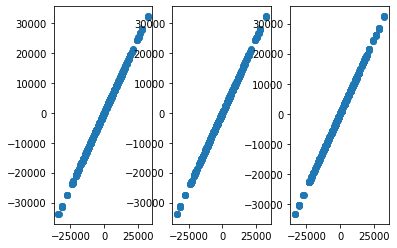

In [26]:
y_pred = least_square_solver.predict(dataset)
y_pred_b = least_square_solver_batch.predict(dataset)

y_pred_x = least_square_solver.predict_x(dataset)
y_pred_b_x = least_square_solver_batch.predict_x(dataset)

fig, axe = plt.subplots(nrows = 1, ncols = 3)
axe[0].scatter(y_pred['y'], y_pred['y_pred'])
axe[1].scatter(y_pred['y_pred'], y_pred_b['y_pred'])
axe[2].scatter(y_pred_x['y_pred_from_x'], y_pred_b_x['y_pred_from_x'])


In [27]:
least_square_solver.normalizer

False

In [28]:
for x in dataset:
    print(x[0].shape)

(200, 300)


In [29]:
print(abs(y_pred_b['y_pred'] - y_pred_b['y']) - abs(y_pred['y_pred'] - y_pred['y']))

[[-0.015625   -0.00976562 -0.02148438  0.00585938]
 [-0.00146484  0.01977539  0.00366211  0.00048828]
 [ 0.02001953  0.01269531  0.01855469  0.01269531]
 [-0.01367188 -0.01855469 -0.01464844 -0.02441406]
 [-0.01757812 -0.01171875 -0.00097656 -0.00585938]
 [ 0.01708984  0.01708984  0.01074219  0.02148438]
 [-0.0078125  -0.00195312  0.         -0.00390625]
 [ 0.00634766  0.01074219  0.01708984  0.0078125 ]
 [-0.00195312 -0.01171875 -0.01367188 -0.02148438]
 [-0.02148438 -0.00488281 -0.01855469  0.00488281]
 [ 0.01025391 -0.00976562  0.          0.00585938]
 [-0.04882812 -0.03710938 -0.02148438 -0.03613281]
 [-0.00610352 -0.00708008 -0.00415039 -0.01293945]
 [ 0.01416016  0.01757812  0.00634766  0.02587891]
 [-0.00219727  0.00610352 -0.00756836  0.00488281]
 [-0.00292969  0.          0.00390625  0.00097656]
 [-0.0078125  -0.00390625 -0.01953125 -0.00292969]
 [ 0.          0.0078125   0.00097656  0.00390625]
 [ 0.01757812  0.01513672  0.01611328  0.01074219]
 [-0.00097656  0.00683594  0.00

In [30]:
print(abs(y_pred_b_x['y_pred_from_x'] - y_pred_b_x['y']) - abs(y_pred_x['y_pred_from_x'] - y_pred_x['y']))

[[-185.76562   -180.48828   -174.95312   -169.5      ]
 [ 197.57959    193.17627    188.57617    184.06055  ]
 [-185.40381   -211.75732   -204.98828   -198.3252   ]
 [-185.2461    -180.37207   -175.24316   -170.21484  ]
 [-181.61035   -176.59473   -171.3125    -166.14746  ]
 [-178.5376    -174.08496   -169.35791   -164.76025  ]
 [ 221.90039    216.23242    210.33594    204.54688  ]
 [ 200.04688    195.25293    190.20654    185.25098  ]
 [ 238.65039    232.5293     226.21875    219.95898  ]
 [-108.59473   -142.85059   -176.92871   -181.41797  ]
 [ 197.25928    193.16504    188.8711     184.6582   ]
 [ 206.08496    201.76758    197.26562    192.80713  ]
 [-219.6604    -212.88892   -205.88696   -198.9707   ]
 [ 199.70264    196.18652    192.43799    188.78076  ]
 [-192.86914   -187.64502   -182.14307   -176.78369  ]
 [ 205.7168     200.4248     194.90527    189.48535  ]
 [ 188.23438    185.22559    181.95703    178.81934  ]
 [ 225.27148    219.47949    213.50488    207.59863  ]
 [ 202.130

In [31]:
# tf.reduce_sum(tf.multiply(least_square_solver.svd.v[:,0], least_square_solver.svd.v[:,1]))
# least_square_solver.svd.v

# Testing partial R2

In [32]:
n = 200
k = 3
n_outcome = 4
kcovar = 10
beta = np.reshape(np.array(range(1, k * n_outcome + 1)), newshape = [k, n_outcome])
bcovar = np.reshape(np.array(range(1, kcovar * n_outcome + 1)), newshape = [kcovar, n_outcome]) * 0.2
intercepts = np.array([230, 250, 270, 290])

x = np.random.normal(size = [n, k])
covar = np.random.normal(size = [n, kcovar])
y = np.matmul(x, beta) + np.matmul(covar, bcovar) + np.random.normal(size = [n, n_outcome]) + intercepts

dataset = tf.data.Dataset.from_tensor_slices((x, np.concatenate((y, covar), axis = 1)))
dataset = dataset.map(lambda x, y: (tf.cast(x, tf.float32), tf.cast(y, tf.float32)))
dataset = dataset.batch(300)
data_scheme = lib_LinearAlgebra.DataScheme(
    dataset = dataset, 
    X_index = 0,
    Y_index = 1,
    outcome_indice = [0, 1, 2, 3], 
    covariate_indice = [4, 5]
)

least_square_solver = lib_LinearAlgebra.LeastSquaredEstimator(data_scheme, intercept = True)
least_square_solver.solve()

least_square_solver_batch = lib_LinearAlgebra.LeastSquaredEstimator(data_scheme, intercept = True, normalizer = True)
norm = least_square_solver_batch.solve(return_normalizer = True)
least_square_solver.data_scheme.covariate_indice

[4, 5]

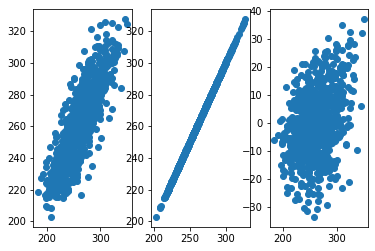

In [33]:
y_pred = least_square_solver.predict(dataset)
y_pred_b = least_square_solver_batch.predict(dataset)

y_pred_x = least_square_solver.predict_x(dataset)
y_pred_b_x = least_square_solver_batch.predict_x(dataset)

fig, axe = plt.subplots(nrows = 1, ncols = 3)
axe[0].scatter(y_pred['y'], y_pred['y_pred'])
axe[1].scatter(y_pred['y_pred'], y_pred_b['y_pred'])
axe[2].scatter(y_pred_x['y'], y_pred_x['y_pred_from_x'])

In [34]:
least_square_solver.partial_r2(dataset, logging = logging)
# y_pred_b_x['y_pred_from_x'][(0,1)]
# dataset.element_spec

2020-02-01 04:18:59 PM  Partial R2 Processing 0 / 4
2020-02-01 04:18:59 PM  now processing outcome index 0
2020-02-01 04:19:00 PM  Partial R2 Processing 1 / 4
2020-02-01 04:19:00 PM  now processing outcome index 1
2020-02-01 04:19:00 PM  Partial R2 Processing 2 / 4
2020-02-01 04:19:00 PM  now processing outcome index 2
2020-02-01 04:19:00 PM  Partial R2 Processing 3 / 4
2020-02-01 04:19:00 PM  now processing outcome index 3


array([[2.91558862e-01, 4.49747344e+04, 6.34840820e+04],
       [3.31007540e-01, 4.82421719e+04, 7.21116797e+04],
       [3.69009197e-01, 5.23506484e+04, 8.29657891e+04],
       [4.07446086e-01, 5.61196016e+04, 9.47080078e+04]])

# Test quick partial R2 implementation

In [59]:
import util_Stats
util_Stats = reload(util_Stats)

In [44]:
y = y_pred_x['y']
yp = np.reshape(y_pred_x['y_pred_from_x'], (y_pred_x['y_pred_from_x'].shape[0], y_pred_x['y_pred_from_x'].shape[1], 1))

In [52]:
for i in dataset:
    x, y = data_scheme.get_data_matrix(i, only_x = False)

In [54]:
x = x[:, -len(data_scheme.covariate_indice):]

In [60]:
partial_r2 = util_Stats.quick_partial_r2(x, y, yp)

In [61]:
partial_r2

array([[0.29156673],
       [0.33102124],
       [0.36900243],
       [0.40745427]])